# Error Plots for JCPexample 2

## Unsteady Stokes Flow in Rotating Disk

### Import Stuff

In [1]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat

import DRLPDE_nn
import DRLPDE_param_solver
import DRLPDE_functions.DefineDomain
import DRLPDE_functions.EvaluateWalkers

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']

### Load Model and Setup Variables

In [2]:
loadmodel = 'JCPexample2'

imagefilename = 'Error_Plot_' + loadmodel
imagesfolder = "images/"

model = torch.load("savedmodels/" + loadmodel + ".pt").to('cpu')

dim_space = 2
dim_full = dim_space + 1

mu = 1
L = 1  # Length of box the circle/sphere sits inside + Radius of Disk/Sphere
v0 = 1
maxT = 0.25 # Max time

numpts_r = 20
numpts_th =  120
numpts_time = 100
dtime = maxT/numpts_time

r,th,t_var = torch.meshgrid([torch.linspace(0,1, numpts_r), \
                         torch.linspace(0,2*math.pi, numpts_th), \
                         torch.linspace(0,maxT, numpts_time+1)])

x1g = r*torch.cos(th)
x2g = r*torch.sin(th)

xg = torch.stack([x1g.reshape(-1), x2g.reshape(-1), t_var.reshape(-1)], dim=-1)

#### Analytic Solution

u1_true = - v0*r*torch.sin(th)
u2_true = v0*r*torch.cos(th)

Truncate = 20

roots = bessel.jn_zeros(1,Truncate)

c = np.zeros(Truncate)

for jj in range(0,Truncate):
    c[jj] = 2*(-bessel.j0(roots[jj])/roots[jj])/(bessel.jv(2,roots[jj])**2) # Much more accurate for later terms

    u1_true += v0*c[jj]*torch.sin(th)*torch.tensor(bessel.j1(roots[jj]*r.numpy()))*torch.exp(-mu*roots[jj]**2*t_var)
    u2_true += -v0*c[jj]*torch.cos(th)*torch.tensor(bessel.j1(roots[jj]*r.numpy()))*torch.exp(-mu*roots[jj]**2*t_var)

u1_true[0:-1, :, 0] = 0
u2_true[0:-1, :, 0] = 0
u_true = torch.stack([u1_true, u2_true], dim=-1)

####################################################################

u1_true = u1_true.numpy()
u2_true = u2_true.numpy()

L2_error_U = 0 
L2_error_V = 0

Linf_error_U = 0
Linf_error_V = 0

L2_norm_true_U = 0
L2_norm_true_V = 0

Linf_norm_true = np.max(np.abs(u_true.numpy()))

############# Plot, Video, Error ##################################

r_plot, th_plot = torch.meshgrid([torch.linspace(0,1, numpts_r),
                                 torch.linspace(0,2*math.pi, numpts_th)])

x1plot = r_plot*torch.cos(th_plot)
x2plot = r_plot*torch.sin(th_plot)

xplot = torch.stack( [x1plot.reshape(-1), x2plot.reshape(-1), torch.zeros((numpts_r*numpts_th))], dim=-1).requires_grad_(True)

integral_factor = 2*math.pi*maxT*r_plot/(numpts_r-1)/(numpts_th-1)/(numpts_time-1)
integral_factor = integral_factor.numpy()

x1plot = x1plot.numpy()
x2plot = x2plot.numpy()

for ii in range(0,numpts_time):
    index = '0' + str(ii)
    
    xplot.requires_grad_(False)
    xplot[:,2] = dtime*ii

    Trained_Vel = model(xplot.requires_grad_(True)).reshape([numpts_r, numpts_th, 2]).detach().numpy()

    Trained_Vel_U = Trained_Vel[:,:,0]
    Trained_Vel_V = Trained_Vel[:,:,1]    


    ### All the different Errors and norms ###

    L2_error_U +=  np.sum( ((Trained_Vel_U - u1_true[:,:,ii])**2 )*integral_factor)
    L2_error_V +=  np.sum( ((Trained_Vel_V - u2_true[:,:,ii])**2 )*integral_factor)

    Linf_error_U = np.max([np.max(np.abs(Trained_Vel_U - u1_true[:,:,ii])), Linf_error_U])
    Linf_error_V = np.max([np.max(np.abs(Trained_Vel_V - u2_true[:,:,ii])), Linf_error_V])

    L2_norm_true_U += np.sum( (u1_true[:,:,ii]**2)*integral_factor )
    L2_norm_true_V += np.sum( (u2_true[:,:,ii]**2)*integral_factor )
    

L2_error = np.sqrt(L2_error_U + L2_error_V)
Linf_error = np.max( [Linf_error_U, Linf_error_V])
L2_norm_true = np.sqrt( L2_norm_true_U + L2_norm_true_V )

print('L2_error = {:.4f}'.format(L2_error))

print('Linf_error = {:.4f}'.format(Linf_error))

print('Relative L2_error = {:.4f}'.format(L2_error/L2_norm_true))

print('Relative Linf_error = {:.4f}'.format(Linf_error/Linf_norm_true))

C:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


L2_error = 0.0792
Linf_error = 1.0160
Relative L2_error = 0.1348
Relative Linf_error = 1.0160


### Plotting

[Text(0, -1.0, ''),
 Text(0, -0.75, ''),
 Text(0, -0.5, ''),
 Text(0, -0.25, ''),
 Text(0, 0.0, ''),
 Text(0, 0.25, ''),
 Text(0, 0.5, ''),
 Text(0, 0.75, ''),
 Text(0, 1.0, '')]

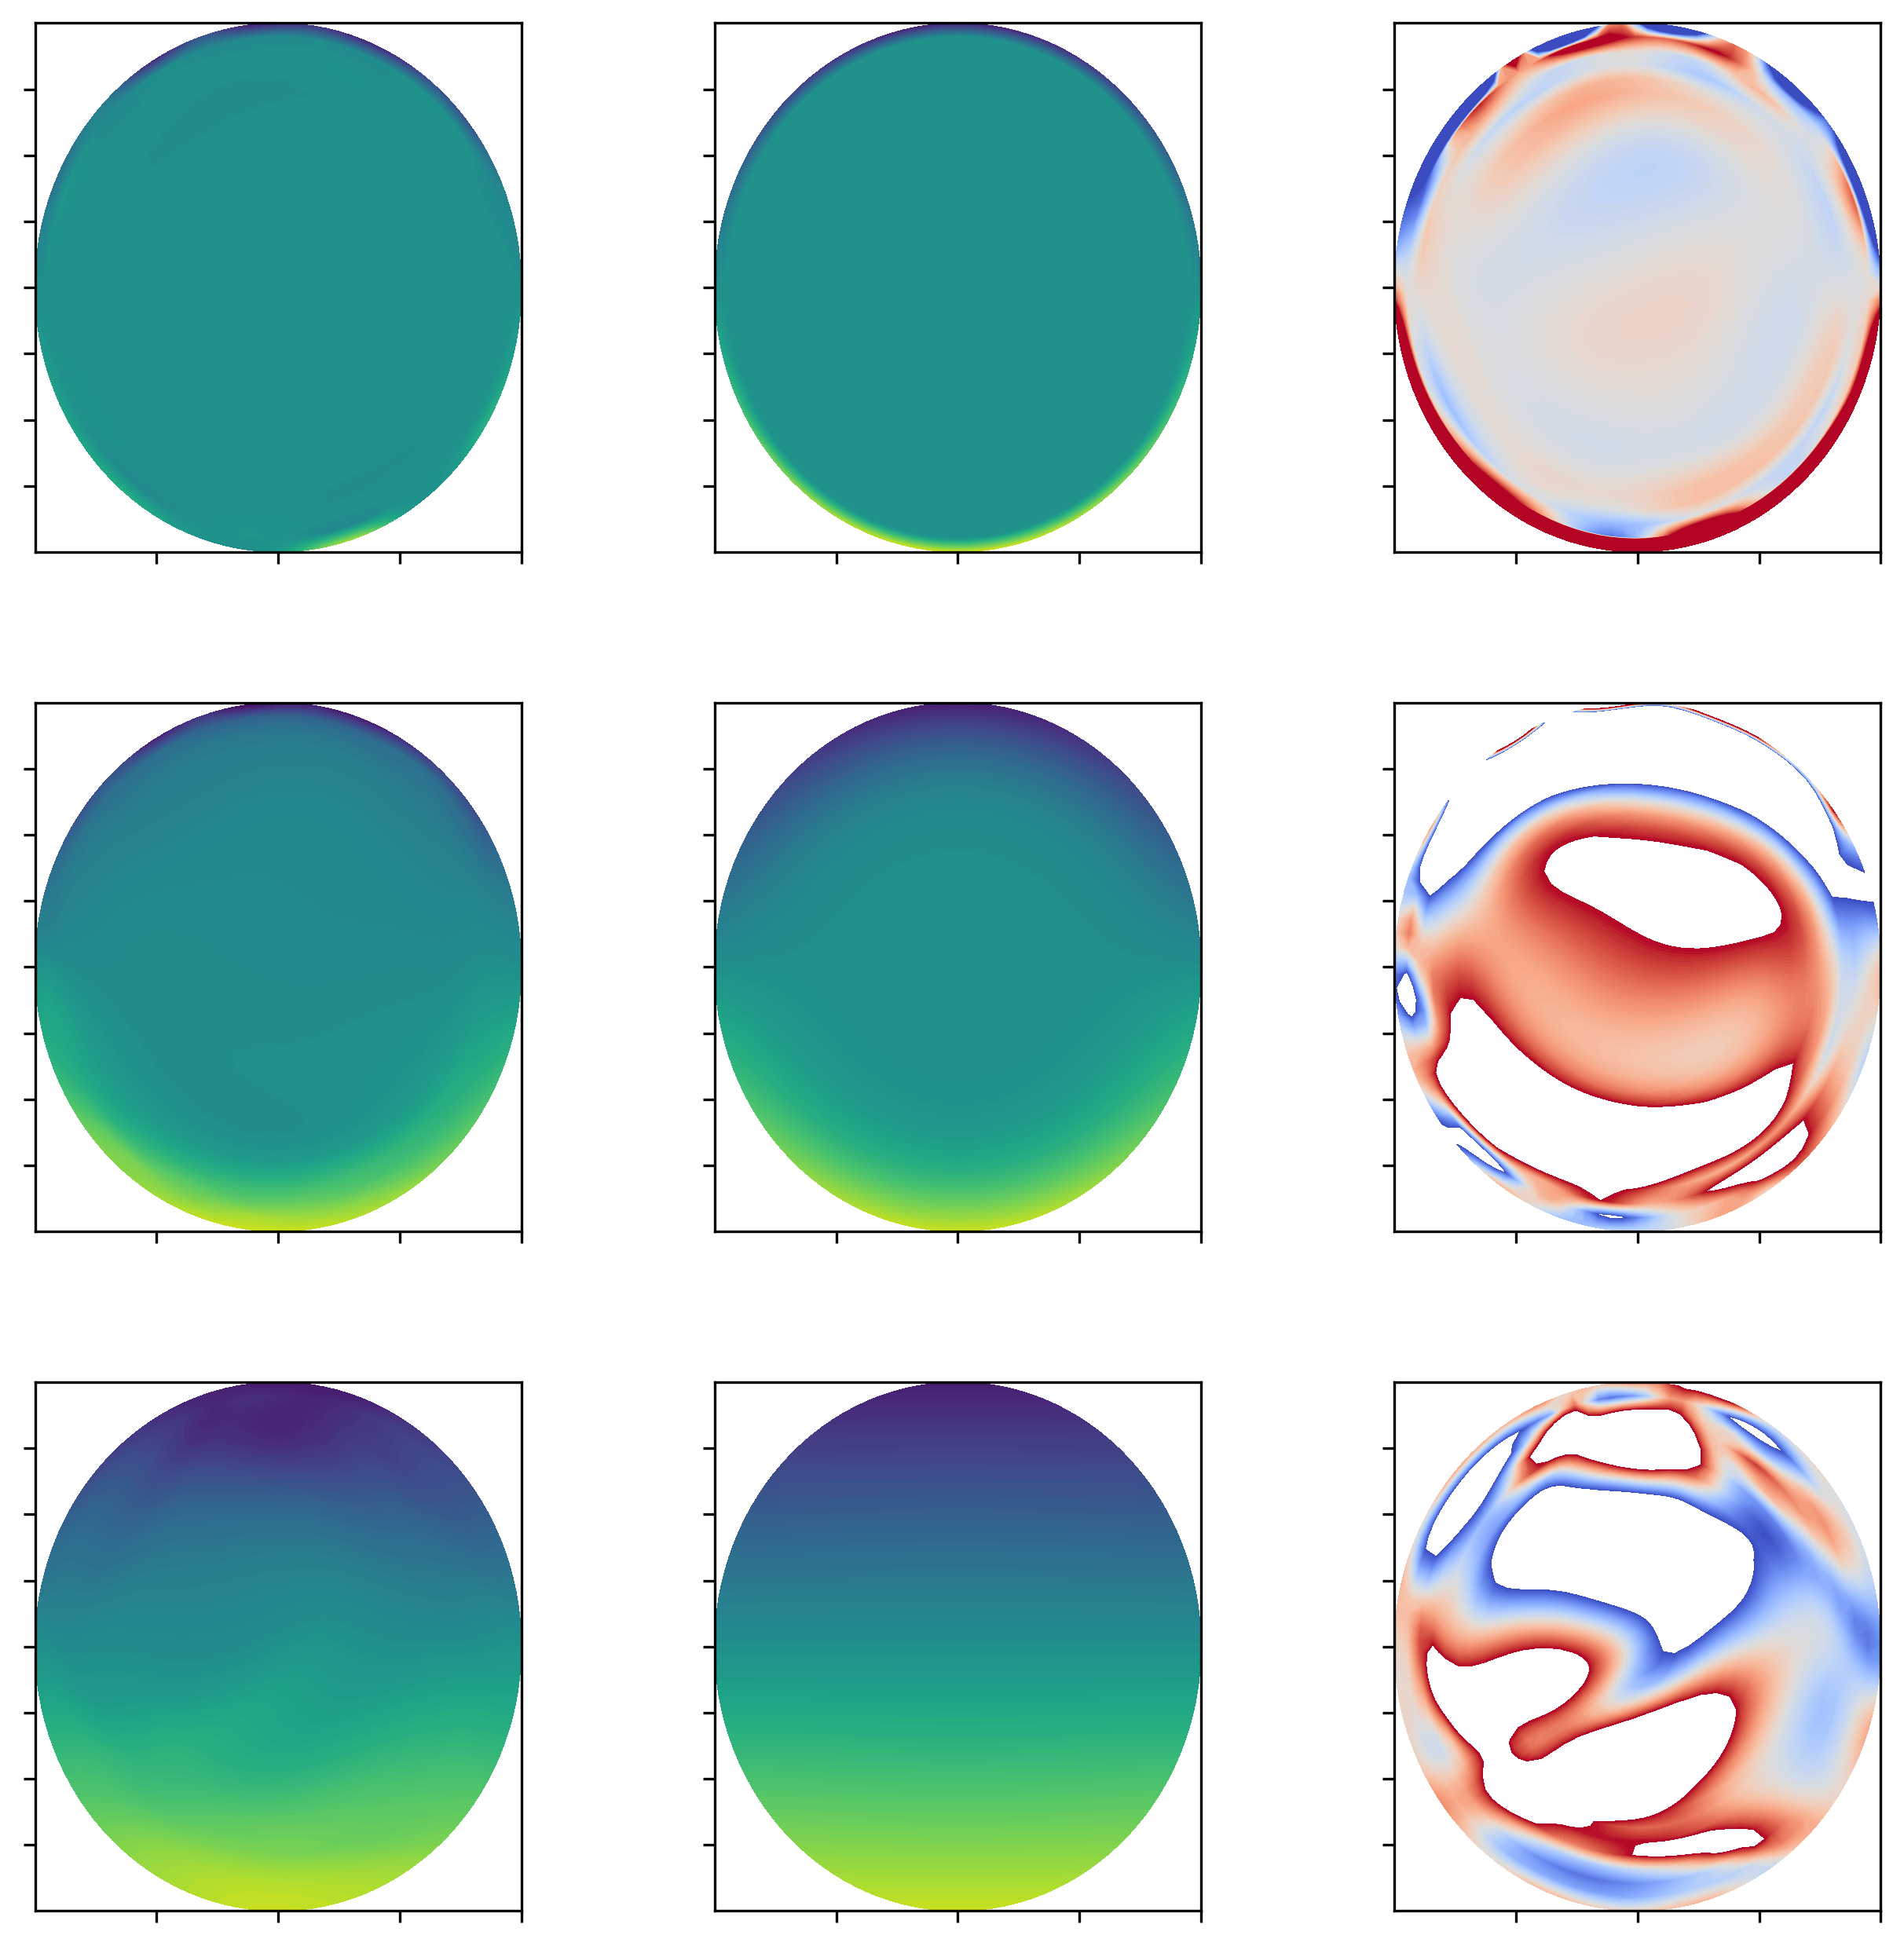

In [3]:
xplot.requires_grad = False
xplot[:,2] = 0
xplot.requires_grad = True

Trained_Vel = model(xplot).reshape([numpts_r, numpts_th, 2]).detach().numpy()

Trained_Vel_U_t0 = Trained_Vel[:,:,0]
u1_true_t0 = u1_true[:,:,0]

xplot.requires_grad = False
xplot[:,2] = dtime*9
xplot.requires_grad = True

Trained_Vel = model(xplot).reshape([numpts_r, numpts_th, 2]).detach().numpy()

Trained_Vel_U_t1 = Trained_Vel[:,:,0]
u1_true_t1 = u1_true[:,:,9]   

xplot.requires_grad = False
xplot[:,2] = dtime*99
xplot.requires_grad = True

Trained_Vel = model(xplot).reshape([numpts_r, numpts_th, 2]).detach().numpy()

Trained_Vel_U_t2 = Trained_Vel[:,:,0]
u1_true_t2 = u1_true[:,:,99] 

#############################################################################

levels_stokes = np.linspace(-1.2, 1.2, 100)
error_levels = np.linspace(-0.05, 0.05, 100)

levels_tick = np.linspace(-1.0, 1.0, 3)
error_tick = np.linspace(-0.05, 0.05, 3)

plt.close('all')
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
plt.tight_layout(pad=2.5)
#fig.suptitle('Comparison of Unsteady Stokes in Disk', fontsize=20, y=1.00)

contour0 = ax[0,0].contourf(x1plot, x2plot, Trained_Vel_U_t0, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
                            
#ax1.set_title(r'Neural Network Approximation of u velocity')
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
#ax[0,0].annotate(r'time = 0', xy=(0, 0.5), xycoords=ax[0,0].yaxis.label, 
#                 size='large', ha='right', va='center')
#plt.colorbar(contour0, ticks = levels_tick, ax=ax[0,0])

contour1 = ax[0,1].contourf(x1plot, x2plot, u1_true_t0, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
#ax2.set_title(r'Analytic Solution of u by Finite Difference')
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
#plt.colorbar(contour1, ticks = levels_tick, ax=ax[0,1])

contour2 = ax[0,2].contourf(x1plot, x2plot, u1_true_t0 - Trained_Vel_U_t0, 
                            levels = error_levels, cmap=plt.cm.coolwarm, extend='both')
#ax3.set_title(r'Difference between Analytic and Neural Network of u')
ax[0,2].set_xticklabels([])
ax[0,2].set_yticklabels([])
#plt.colorbar(contour2, ticks = error_tick, ax=ax[0,2])

contour3 = ax[1,0].contourf(x1plot, x2plot, Trained_Vel_U_t1, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])
#ax[1,0].annotate(r'time = 0.125', xy=(0, 0.5), xycoords=ax[1,0].yaxis.label, 
#                 size='large', ha='right', va='center')
#plt.colorbar(contour3, ticks = levels_tick, ax=ax[1,0])

contour4 = ax[1,1].contourf(x1plot, x2plot, u1_true_t1, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
#plt.colorbar(contour4, ticks = levels_tick, ax=ax[1,1])

contour5 = ax[1,2].contourf(x1plot, x2plot, u1_true_t1 - Trained_Vel_U_t1, 
                            error_levels, cmap=plt.cm.coolwarm)
ax[1,2].set_xticklabels([])
ax[1,2].set_yticklabels([])
#plt.colorbar(contour5, ticks=error_tick, ax=ax[1,2])

contour6 = ax[2,0].contourf(x1plot, x2plot, Trained_Vel_U_t2, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
ax[2,0].set_xticklabels([])
ax[2,0].set_yticklabels([])
#ax[2,0].annotate(r'time = 0.25', xy=(0, 0.5), xycoords=ax[2,0].yaxis.label, 
#                 size='large', ha='right', va='center')
#plt.colorbar(contour6, ticks = levels_tick, ax=ax[2,0])

contour7 = ax[2,1].contourf(x1plot, x2plot, u1_true_t2, 
                            levels=levels_stokes, cmap=plt.cm.viridis)
ax[2,1].set_xticklabels([])
ax[2,1].set_yticklabels([])
#plt.colorbar(contour7, ticks = levels_tick, ax=ax[2,1])

contour8 = ax[2,2].contourf(x1plot, x2plot, u1_true_t2 - Trained_Vel_U_t2, 
                            error_levels, cmap=plt.cm.coolwarm)
ax[2,2].set_xticklabels([])
ax[2,2].set_yticklabels([])
#plt.colorbar(contour8, ticks=error_tick, ax=ax[2,2])
